In [45]:
import pandas as pd
import pedpy
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
from pathlib import Path
import glob

# ---
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
import seaborn as sns
import itertools
from matplotlib.patches import FancyArrowPatch

In [2]:
rename_mapping = {
    "ID": "id",
    "t(s)": "time",
    "x(m)": "x",
    "y(m)": "y",
}
column_types = {
    "id": int,
    "gender": int,
    "time": float,
    "x": float,
    "y": float,
}
countries = [
    "aus",
    "ger",
    "jap",
    "chn",
    "pal",
]
files = {}
for country in countries:
    files[country] = glob.glob(f"../data/{country}/*.csv")

In [3]:
def perform_polynomial_regression(data, x_column, y_column, degree=2, test_size=0.2):
    """
    Perform polynomial regression on a given dataset.

    Parameters:
    - data: DataFrame containing the dataset.
    - x_column: The name of the column to use as the independent variable.
    - y_column: The name of the column to use as the dependent variable.
    - degree: The degree of the polynomial regression.
    - test_size: Fraction of the dataset to be used as test set.

    Returns:
    - X_fit: The x values used for fitting the model, useful for plotting.
    - y_fit: The predicted y values corresponding to X_fit.
    - metrics: A dictionary containing the MSE and R^2 metrics for the model.
    """

    # Prepare the data
    X = data[x_column].values.reshape(-1, 1)
    y = data[y_column].values

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Create a PolynomialFeatures object with the specified degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the features into polynomial features
    X_poly_train = poly.fit_transform(X_train)

    # Create and fit the model
    model = LinearRegression()
    model.fit(X_poly_train, y_train)

    # Transform the test data
    X_poly_test = poly.transform(X_test)

    # Predictions on the test data
    y_pred = model.predict(X_poly_test)

    # Evaluation
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    metrics = {"MSE": mse, "R2": r2}

    # For plotting, generate a range of x values covering the observed range
    X_fit = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    X_fit_poly = poly.transform(X_fit)
    y_fit = model.predict(X_fit_poly)

    return X_fit[:, 0], y_fit, metrics

In [13]:
def weidmann(x, a1, a2, a3):
    return a1 * (1 - np.exp(-a2 * (1 / x - 1 / a3)))


p0 = [1.2, 1.2, 0.3]
def fitting(X, Y):
    def func(x, a, b, c):
        return a * np.exp(-b * x) + c

    try:
        popt, pcov = curve_fit(weidmann, X, Y, p0=p0, maxfev=800)
        print(f"{popt[0]:.2f} & {popt[1]:.2f} & {popt[2]:.2f}")
        return X, weidmann(X, *popt), popt
    except RuntimeError as e:
        print(f"Error: {e}")
        print("Optimal parameters not found. Returning default values or handling the error gracefully.")
        return None, None, None  # or some other fallback behavior

In [5]:
# x = np.arange(0.1, 4, 0.1)
# y =weidmann(x, *p0)
# plt.plot(x, y)

In [6]:
def load_file(filename: str) -> pedpy.TrajectoryData:
    def calculate_fps(data: pd.DataFrame) -> int:
        """Calculate fps based on the mean difference of the 'time' column."""
        mean_diff = data.groupby("id")["time"].diff().dropna().mean()
        return int(round(1 / mean_diff))

    def set_column_types(data: pd.DataFrame, col_types) -> pd.DataFrame:
        """Set the types of the dataframe columns based on the given column types."""
        # Ensure columns are in data before type casting
        valid_types = {
            col: dtype for col, dtype in col_types.items() if col in data.columns
        }
        return data.astype(valid_types)

    data = pd.read_csv(filename)
    data.rename(columns=rename_mapping, inplace=True)
    data = set_column_types(data, column_types)
    fps = calculate_fps(data)
    return pedpy.TrajectoryData(data=data, frame_rate=fps)

In [7]:
csv_file = "../app_data/proximity_analysis_results_euc.csv"
df = pd.read_csv(csv_file)

In [8]:
def calculate_individual_density_csv(data: pd.DataFrame) -> pd.DataFrame:
    """Calculate Voronoi density."""
    # Replace None values with NaN
    columns = [
        "same_gender_proximity_prev",
        "same_gender_proximity_next",
        "diff_gender_proximity_prev",
        "diff_gender_proximity_next",
    ]
    data.loc[:, columns].replace({None: np.nan}, inplace=True)

    # Calculate half sum distances
    half_sum_distances = 0.5 * (
        data["same_gender_proximity_prev"].fillna(0)
        + data["diff_gender_proximity_prev"].fillna(0)
        + data["same_gender_proximity_next"].fillna(0)
        + data["diff_gender_proximity_next"].fillna(0)
    )

    # Avoid division by zero
    half_sum_distances.replace(0, np.nan, inplace=True)

    # Calculate individual density
    individual_density = 1 / half_sum_distances

    return pd.DataFrame(
        {
            "frame": data["frame"],
            "id": data["id"],
            "individual_density": individual_density,
        }
    )

## Calculate density and Speed


In [9]:
all_merged_df = pd.DataFrame()
for country in countries:
    print(f" {country = }")
    for filename in files[country]:
        trajectory_data = load_file(filename)
        new_path = "/".join(Path(filename).parts[-2:])
        filter_df = df[(df["country"] == country) & (df["file"] == new_path)]
        if filter_df["type"].empty:
            print(filename, new_path)
            print(filter_df)
            continue
        unique_gender = filter_df["type"].iloc[0]
        density = calculate_individual_density_csv(filter_df)
        speed = pedpy.compute_individual_speed(
            traj_data=trajectory_data,
            frame_step=10,
            speed_calculation=pedpy.SpeedCalculation.BORDER_EXCLUDE,
        )

        merged_df = pd.merge(density, speed, on=["id", "frame"])
        coords = trajectory_data.data[["id", "frame", "x", "y"]].drop_duplicates()
        merged_df = pd.merge(merged_df, coords, on=["id", "frame"], how="left")

        merged_df["type"] = unique_gender
        merged_df["country"] = country
        merged_df["file"] = Path(filename).stem
        all_merged_df = pd.concat([all_merged_df, merged_df], ignore_index=True)

 country = 'aus'
 country = 'ger'
 country = 'jap'
 country = 'chn'
 country = 'pal'


## Plot FD for data in Box


In [10]:
alpha = 0.2  # scatter alpha
size = 2  # scatter size
gender_colors = {
    "female": "blue",
    "male": "orange",
    "mix_sorted": "red",
    "mix_random": "green",
}
country_colors = {
    "aus": "blue",
    "ger": "black",
    "jap": "orange",
    "chn": "red",
    "pal": "green",
}

In [11]:
p = plt.rcParams
p["figure.figsize"] = 10, 10
p["font.sans-serif"] = ["Roboto Mono for Powerline"]
p["font.weight"] = "light"
p["ytick.minor.visible"] = True
p["xtick.minor.visible"] = True
p["axes.grid"] = False
p["grid.color"] = "0.5"
p["grid.linewidth"] = 0.5
fig = plt.figure(constrained_layout=True)
nrows, ncols = 4, 3
gspec = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig, height_ratios=[0.05, 1, 1, 1])


def plot(ax, text):
    ax.set_xlabel(r"$\rho\; /\; 1/m$", fontsize=12)
    ax.set_ylabel(r"$s\; /\; m/s$", fontsize=12)
    ax.set_xlim([0, 4])
    ax.set_ylim([-0.0, 2])
    ax.set_title(text, weight=500)
    ax.tick_params(axis="both", which="major", labelsize=12)
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    ax.xaxis.set_major_formatter(FormatStrFormatter("%.1f"))


# for i in range(ncols):
#    ax = plt.subplot(gspec[0, i])
#    plot(ax, "legend subplot(gspec[0,%d])" % i)
# for i in range(ncols):
#    ax = plt.subplot(gspec[1, i])
#    plot(ax, "subplot(gspec[0,%d])" % i)
# for i in range(2, nrows):
#    ax= plt.subplot(gspec[i, 0])
#    plot(ax, "subplot(gspec[%d,0])" % i)
# ax =  plt.subplot(gspec[2:, 1:])
# plot(ax, "subplot(gspec[1:,1:])")

# plt.show()

<Figure size 1000x1000 with 0 Axes>

/var/folders/xp/t78pqmf50rb4s9vh6gdz0ykr0000gq/T/ipykernel_77639/2696036125.py:4: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  sorted_indices_subset = X.argsort()


Error: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Optimal parameters not found. Returning default values or handling the error gracefully.


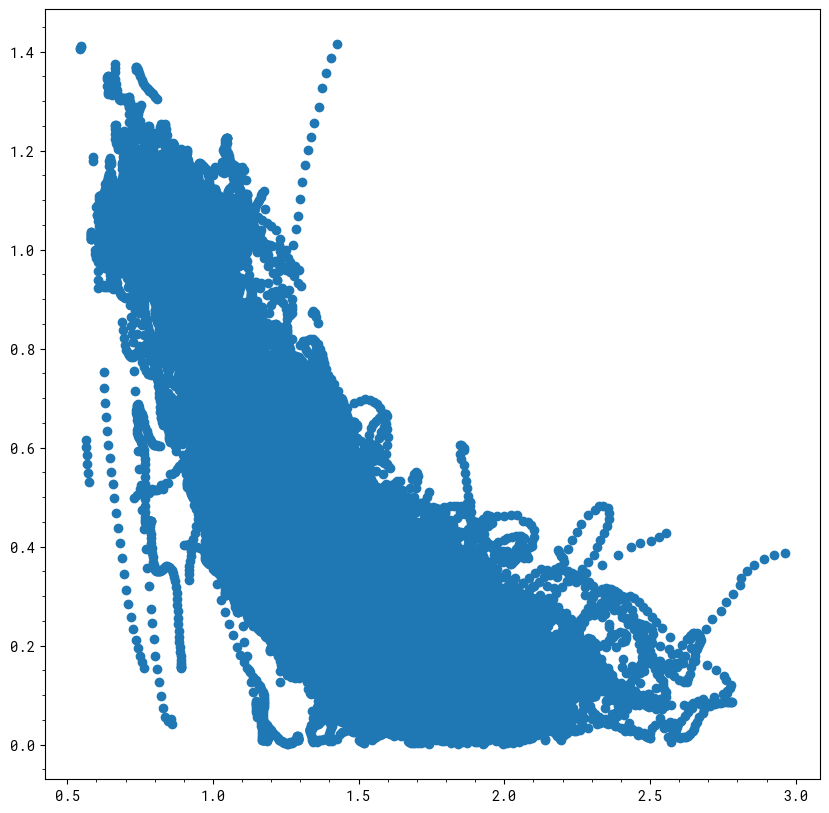

In [29]:
# subset = all_merged_df[(all_merged_df["country"] =='pal') & (all_merged_df["type"] == 'mix_sorted')]
# X, Y = subset["individual_density"], subset["speed"]
# plt.plot(X,Y, 'o')
# sorted_indices_subset = X.argsort()
# X_sorted_subset = X.iloc[sorted_indices_subset]
# Y_sorted_subset = Y.iloc[sorted_indices_subset]
# X_fit_subset, Y_fit_subset, popt_subset = fitting(X_sorted_subset, Y_sorted_subset)

country='aus'
1, ic = 0
gender='female'
1.07 & 1.56 & 2.37
gender='male'
1.27 & 1.53 & 2.23
gender='mix_random'
-3.68 & -0.00 & -0.10
gender='mix_sorted'
-2.41 & -0.02 & -0.58
1.39 & 0.76 & 3.36
country='ger'
1, ic = 1
gender='female'
1.39 & 0.72 & 3.74
gender='male'
1.23 & 1.11 & 2.97
gender='mix_random'
1.29 & 0.99 & 2.94
gender='mix_sorted'
1.24 & 1.08 & 3.22
1.21 & 1.06 & 3.19
country='jap'
1, ic = 2
gender='female'
1.31 & 0.97 & 2.52
gender='male'
1.21 & 1.01 & 2.65
gender='mix_random'
1.40 & 0.80 & 2.70
gender='mix_sorted'
subset is empty
1.22 & 0.99 & 2.66
country='chn'
ic-1 = 2, 0
gender='female'
2.32 & 0.44 & 2.59
gender='male'
2.73 & 0.30 & 4.01
gender='mix_random'
2.51 & 0.36 & 3.10
gender='mix_sorted'
2.52 & 0.36 & 3.10
2.04 & 0.43 & 3.52
country='pal'
ic-1 = 3, 0
gender='female'


/var/folders/xp/t78pqmf50rb4s9vh6gdz0ykr0000gq/T/ipykernel_77639/2038263479.py:90: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  sorted_indices_subset = X.argsort()


Error: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Optimal parameters not found. Returning default values or handling the error gracefully.
gender='male'


/var/folders/xp/t78pqmf50rb4s9vh6gdz0ykr0000gq/T/ipykernel_77639/2038263479.py:90: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  sorted_indices_subset = X.argsort()


Error: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Optimal parameters not found. Returning default values or handling the error gracefully.
gender='mix_random'
subset is empty
gender='mix_sorted'


/var/folders/xp/t78pqmf50rb4s9vh6gdz0ykr0000gq/T/ipykernel_77639/2038263479.py:90: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  sorted_indices_subset = X.argsort()


Error: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Optimal parameters not found. Returning default values or handling the error gracefully.
1.74 & 1.13 & 2.21


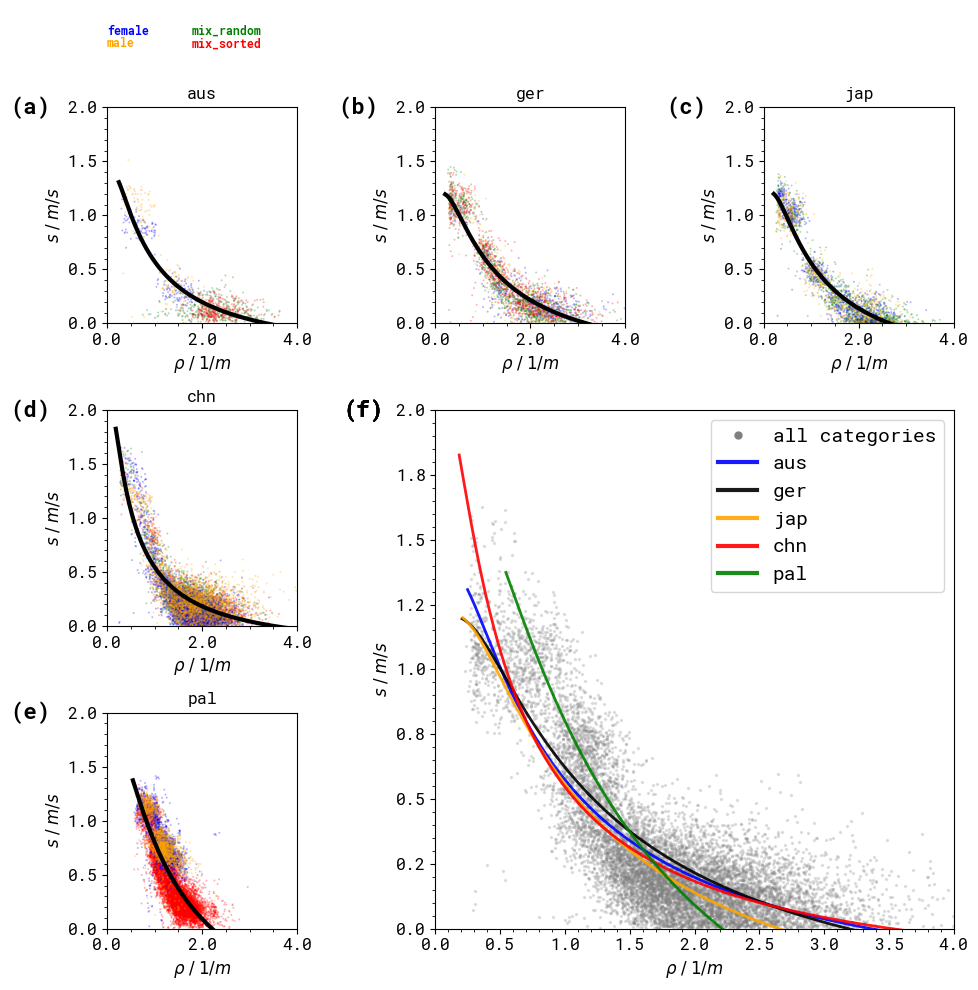

In [32]:
panel_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(f)']
genders = all_merged_df["type"].unique()
x_from = -1.4
x_to = 1.4
y_from = -2
y_to = -1
xfits = []
yfits = {}
popts = {}

ax_legend = plt.subplot(gspec[0, :], frameon=False)
ax_legend.set(xlim=[0, 10], xticks=[], ylim=[0, 4], yticks=[])
ax_legend.axis("off")

# Positions for the 2x2 grid within the legend subplot
positions = [(0.0, -4), (0.0, -8.5), (1, -4), (1, -8.5)]
texts = ["female", "male", "mix_random", "mix_sorted"]

# Adding the text elements
for (x, y), text in zip(positions, texts):
    ax_legend.text(x, y, text, ha="left", va="center", size="small", weight="bold", color=gender_colors[text])

ax_legend.axhline(0.5, color="white", lw=1)
for ic, country in enumerate(countries[:]):
    # row = ic // ncols  # Integer division to increment row every 'ncols' plots
    # col = ic % ncols   # Modulo operation to wrap around the column index
    # ax = plt.subplot(gspec[row, col])
    print(f"{country=}")
    legend_handles = []
    # plt.figure(figsize=(6, 6))
    # print(f"{ic = }"   )
    if ic <= 2:
        ax = plt.subplot(gspec[1, ic])
        print(f"1, {ic = }")
    else:
        ax = plt.subplot(gspec[ic - 1, 0])
        print(f"{ic-1 = }, 0")

    # Add panel label to each subplot
    ax.text(-0.3, 1.05, panel_labels[ic], transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top', ha='right')

    ax_last = plt.subplot(gspec[2:, 1:])
    ax_last.text(-0.1, 1.02, panel_labels[-1], transform=ax_last.transAxes,
            fontsize=16, fontweight='bold', va='top', ha='right')
    for i, gender in enumerate(genders):
        print(f"{gender=}")
        if country != "pal":
            subset = all_merged_df[
                (all_merged_df["country"] == country)
                & (all_merged_df["type"] == gender)
                & (all_merged_df["x"] > x_from)
                & (all_merged_df["x"] < x_to)
                & (all_merged_df["y"] > y_from)
                & (all_merged_df["y"] < y_to)
            ]
        else:
            subset = all_merged_df[(all_merged_df["country"] == country) & (all_merged_df["type"] == gender)]
        if subset.empty:
            print("subset is empty")
            continue

        plot(ax, country)
        zorder = -10
        if country == "pal" and gender == "mix_sorted":
            zorder = -20
        if country == "jap":
            if gender == "mix_random":
                zorder = -20
            if gender == "mix_sorted":
                zorder = -19
        if country == "chn":
            if gender == "mix_sorted":
                zorder = -20
            if gender == "mix_random":
                zorder = -19

        ax.scatter(
            subset["individual_density"][::10],
            subset["speed"][::10],
            label=gender,
            alpha=0.3,
            edgecolor="None",
            s=size,
            zorder=zorder,
            color=gender_colors[gender],
        )
        #plot fits per category
        X, Y = subset["individual_density"], subset["speed"]
        sorted_indices_subset = X.argsort()
        X_sorted_subset = X.iloc[sorted_indices_subset]
        Y_sorted_subset = Y.iloc[sorted_indices_subset]
        X_fit_subset, Y_fit_subset, popt_subset = fitting(X_sorted_subset, Y_sorted_subset)
        australia_special = (country == "aus") and (gender == "mix_sorted")
        australia_special2 = (country == "aus") and (gender == "mix_random")
        if X_fit_subset is not None and not australia_special and not australia_special2:
            #xfits.append(X_fit_subset)
            #yfits[country] = Y_fit_subset
            #popts[country] = popt_subset
            continue
            ax.plot(X_fit_subset, Y_fit_subset, lw=2, color=gender_colors[gender], alpha=1, label="Weidmann", zorder=0)


    country_df = all_merged_df[all_merged_df["country"] == country].dropna()
    X, Y = country_df["individual_density"], country_df["speed"]
    sorted_indices = X.argsort()
    X_sorted = X.iloc[sorted_indices]
    Y_sorted = Y.iloc[sorted_indices]
    X_fit, Y_fit, popt = fitting(X_sorted, Y_sorted)
    xfits.append(X_fit)
    yfits[country] = Y_fit
    popts[country] = popt
    ax.plot(X_fit, Y_fit, lw=3, color="black", alpha=1, label="Weidmann", zorder=0)

all_merged_df.dropna()
legend_handles = []
plot(ax_last, "")
for i, gender in enumerate(genders, start=1):
    # Filter data for each gender
    subset = all_merged_df[all_merged_df["type"] == gender]
    scatter = ax_last.scatter(
        subset["individual_density"][::100],
        subset["speed"][::100],
        label=gender,
        alpha=0.2,
        s=size,
        zorder=2,
        color="gray",  # colors[gender]
    )
legend_handle = plt.Line2D(
    [],
    [],
    marker="o",
    color="gray",
    linestyle="None",
    markersize=5,
    label="all categories",
)
legend_handles.append(legend_handle)

#X, Y = all_merged_df["individual_density"].dropna(), all_merged_df["speed"].dropna()
#sorted_indices = X.argsort()
#X_sorted = X.iloc[sorted_indices]
#Y_sorted = Y.iloc[sorted_indices]
#X_fit, Y_fit, popt = fitting(X_sorted, Y_sorted)
#ax_last.plot(X_fit, Y_fit, lw=3, color="black", alpha=1, label="all")
#legend_handle = plt.Line2D([], [], color="black", alpha=1, linestyle="-", lw=3, label="fit - all")
#legend_handles.append(legend_handle)

# plot all fits
for i, country in enumerate(countries[:]):
    ax_last.plot(xfits[i], yfits[country], lw=2, color=country_colors[country], alpha=0.9)
    legend_handle = plt.Line2D(
        [],
        [],
        color=country_colors[country],
        alpha=0.9,
        linestyle="-",
        lw=3,
        label=f"{country}",
    )
    legend_handles.append(legend_handle)


ax_last.legend(handles=legend_handles, fontsize=14)
# plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.3)
plt.tight_layout()
plt.savefig("FD/FD_all_countries.pdf", dpi=100)
plt.show()

# Statistical tests WIP


In [ ]:
# import pandas as pd
# import scipy.stats as stats
# import statsmodels.api as sm
# from statsmodels.formula.api import ols
# from bioinfokit.analys import stat


# # Convert the dictionary to a DataFrame
# countries = ['Australia', 'Germany', 'Japan', 'China', 'Palestine']
# parameters = ['s_0', 'gamma', 'rho_m']

# # Creating a list of lists from the dictionary values
# data_list = [list(values) for values in popts.values()]

# # Creating the DataFrame
# df = pd.DataFrame(data_list, index=countries, columns=parameters)
# df.reset_index(inplace=True)
# df.rename(columns={'index': 'country'}, inplace=True)
# df


# # Perform ANOVA for each parameter
# for parameter in ['s_0', 'gamma', 'rho_m']:
#     # Define the model formula
#     model_formula = f'{parameter} ~ C(country)'

#     # Fit the model
#     model = ols(model_formula, data=df).fit()
#     print(model.summary())
#     # Perform ANOVA and print the table

#     # anova_table = sm.stats.anova_lm(model, typ=1)
#     # print(anova_table)
#     # print(df[parameter].mean())

In [ ]:
# stats.kruskal(df['s_0'], df['gamma'], df['rho_m'])

The null hypothesis (H0): The median is equal across all groups.
since p< 0.05 we can reject the H0 hypothesis.
We have sufficient evidence to conclude that the country leads to statistically significant differences in the fundamental diagram.


In [ ]:
# from scipy.stats import f_oneway

# #perform one-way ANOVA
# f_oneway(df['s_0'], df['gamma'], df['rho_m'])

H0 (null hypothesis): μ1 = μ2 = μ3 = … = μk (all the population means are equal).

F-statistic: Variation between sample means / Variation within samples

Since p<0.05 we can reject H0


In [ ]:
# from statsmodels.stats.multicomp import pairwise_tukeyhsd

# scores = np.ravel(df.iloc[:, 1:].values)
# groups = np.repeat(df['country'].values, repeats=df.shape[1] - 1)
# dft = pd.DataFrame({
#     'score': scores,
#     'group': groups
# })

# # perform Tukey's test
# tukey = pairwise_tukeyhsd(endog=dft['score'],
#                           groups=dft['group'],
#                           alpha=0.05)

# print(tukey)


In [ ]:
from scipy import stats


def KSD_ci(rho1, v1, rho2, v2, rho_min, rho_max, n_bootstrap=100):
    nBins = 10

    bins = np.linspace(rho_min, rho_max, nBins + 1)

    ks_distances = []

    weights = []

    bootstrapped_cis = []

    bin_centers = []

    for iBin in range(nBins):
        v1_b = v1[(rho1 >= bins[iBin]) & (rho1 < bins[iBin + 1])]

        v2_b = v2[(rho2 >= bins[iBin]) & (rho2 < bins[iBin + 1])]

        bin_weight = len(v1_b) + len(v2_b)

        if len(v1_b) > 0 and len(v2_b) > 0:
            # print(f"{len(v1_b) = }")
            # print(f"{len(v2_b) = }")
            ks_stat, _ = stats.ks_2samp(v1_b, v2_b)

            ks_distances.append(ks_stat)

            weights.append(bin_weight)

            bin_center = (bins[iBin] + bins[iBin + 1]) / 2

            bin_centers.append(bin_center)

            # Bootstrap for confidence interval

            bootstrap_stats = []

            for _ in range(n_bootstrap):
                resample_v1_b = np.random.choice(v1_b, size=len(v1_b), replace=True) if len(v1_b) > 0 else v1_b

                resample_v2_b = np.random.choice(v2_b, size=len(v2_b), replace=True) if len(v2_b) > 0 else v2_b

                bootstrap_stat, _ = stats.ks_2samp(resample_v1_b, resample_v2_b)

                bootstrap_stats.append(bootstrap_stat)

            lower_ci = np.percentile(bootstrap_stats, 2.5)

            upper_ci = np.percentile(bootstrap_stats, 97.5)

            bootstrapped_cis.append((lower_ci, upper_ci))

    weighted_ks_distance = np.average(ks_distances, weights=weights)

    return weighted_ks_distance, bin_centers, ks_distances, bootstrapped_cis

In [ ]:
def plot(ax, title):
    ax.set_xlabel(r"$\rho\; /\; 1/m$", fontsize=12)
    ax.set_ylabel(r"KS distance", fontsize=12)
    ax.set_xlim([0, 4])
    ax.set_ylim([0, 1.2])
    ax.set_title(title, weight=500)
    ax.tick_params(axis="both", which="major", labelsize=12)
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    ax.xaxis.set_major_formatter(FormatStrFormatter("%.1f"))


# Plot the results
def plot_stats(bin_centers, ks_distances, bootstrapped_cis, label, ax):
    plot(ax, label)
    ax.plot(bin_centers, ks_distances, label="KS Distance", marker="o", linestyle="-")
    # Confidence intervals
    lower_cis = [ci[0] for ci in bootstrapped_cis]
    upper_cis = [ci[1] for ci in bootstrapped_cis]
    ax.fill_between(
        bin_centers,
        lower_cis,
        upper_cis,
        color="gray",
        alpha=0.2,
        label=f"95% Confidence Interval ({label})",
    )
    # plt.title(f"KS Distances and Confidence Intervals Across Density Bins {label}")
    # ax.legend(fontsize=14)
    # plt.grid(True)

In [ ]:
datasets_rho = []
datasets_v = []
labels = []
genders = {
    "female",
    "male",
    "mix_sorted",
    "mix_random",
}
for country in countries:
    if country != "pal":
        subset = all_merged_df[
            (all_merged_df["country"] == country) & (all_merged_df["x"] > x_from) & (all_merged_df["x"] < x_to) & (all_merged_df["y"] > y_from) & (all_merged_df["y"] < y_to)
        ]
    else:
        subset = all_merged_df[(all_merged_df["country"] == country)]
    if subset.empty:
        print(f"{country = }, subset is empty")
        continue

    rho = subset["individual_density"]
    v = subset["speed"]
    datasets_rho.append(rho)
    datasets_v.append(v)
    labels.append(f"{country}")


n = len(datasets_rho)
results = np.zeros((n, n))  # Initialize a matrix to store the distances
comparison_details = {}  # Initialize a dictionary to store the details of each comparison
for i, j in itertools.combinations(range(n), 2):
    print(labels[i], labels[j])
    label_i = labels[i]
    label_j = labels[j]
    rho1, rho2 = datasets_rho[i], datasets_rho[j]
    v1, v2 = datasets_v[i], datasets_v[j]
    distance, bin_centers, ks_distances, bootstrapped_cis = KSD_ci(rho1, v1, rho2, v2, rho_min=0.5, rho_max=4)
    results[i, j] = distance
    results[j, i] = distance  # Assuming the distance is symmetric
    comparison_key = f"{label_i} vs {label_j}"
    comparison_details[comparison_key] = {
        "bin_centers": bin_centers,
        "ks_distances": ks_distances,
        "bootstrapped_cis": bootstrapped_cis,
    }

In [ ]:
p = plt.rcParams
p["figure.figsize"] = 10, 10
p["font.sans-serif"] = ["Roboto Mono for Powerline"]
p["font.weight"] = "light"
p["ytick.minor.visible"] = True
p["xtick.minor.visible"] = True
p["axes.grid"] = False
p["grid.color"] = "0.5"
p["grid.linewidth"] = 0.5
fig = plt.figure(constrained_layout=True)
nrows, ncols = 5, 2
gspec = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)

col = 0
row = 0
for k, (i, j) in enumerate(itertools.combinations(range(n), 2)):
    label_i = labels[i]
    label_j = labels[j]

    comparison_key = f"{label_i} vs {label_j}"
    comparison_details[comparison_key]
    ax = plt.subplot(gspec[row, col])
    col += 1
    if col == ncols:
        col = 0
        row += 1

    plot_stats(
        comparison_details[comparison_key]["bin_centers"],
        comparison_details[comparison_key]["ks_distances"],
        comparison_details[comparison_key]["bootstrapped_cis"],
        comparison_key,
        ax=ax,
    )
    if row == nrows:  # If we've filled the last row, stop to avoid IndexError
        print("Max grid size reached. Stopping.")
        break
fig.tight_layout()
fig.savefig("FD/KS_distance.pdf", dpi=100)

In [ ]:
datasets_rho = []
datasets_v = []
labels = []
genders = {
    "female",
    "male",
    "mix_sorted",
    "mix_random",
}
for country in countries:
    for gender in genders:
        if country != "pal":
            subset = all_merged_df[
                (all_merged_df["country"] == country)
                & (all_merged_df["type"] == gender)
                & (all_merged_df["x"] > x_from)
                & (all_merged_df["x"] < x_to)
                & (all_merged_df["y"] > y_from)
                & (all_merged_df["y"] < y_to)
            ]
        else:
            subset = all_merged_df[(all_merged_df["country"] == country) & (all_merged_df["type"] == gender)]
        if subset.empty:
            continue

        rho = subset["individual_density"]
        v = subset["speed"]
        datasets_rho.append(rho)
        datasets_v.append(v)
        labels.append(f"{country}-{gender}")


n = len(datasets_rho)
print(f"Datasets_rho {n=}")
results = np.zeros((n, n))  # Initialize a matrix to store the distances
comparison_details = {}  # Initialize a dictionary to store the details of each comparison
for i, j in itertools.combinations(range(n), 2):
    print(labels[i], labels[j])
    label_i = labels[i]
    label_j = labels[j]
    rho1, rho2 = datasets_rho[i], datasets_rho[j]
    v1, v2 = datasets_v[i], datasets_v[j]

    # distance, bin_centers, ks_distances, bootstrapped_cis = KSD_ci(rho1, v1, rho2, v2, rho_min=0.5, rho_max=4)
    distance, bin_centers, ks_distances, bootstrapped_cis = KSD_ci(rho1, v1, rho2, v2, rho_min=1.0, rho_max=2.5)
    results[i, j] = distance
    results[j, i] = distance  # Assuming the distance is symmetric
    comparison_key = f"{label_i} vs {label_j}"
    comparison_details[comparison_key] = {
        "bin_centers": bin_centers,
        "ks_distances": ks_distances,
        "bootstrapped_cis": bootstrapped_cis,
    }

In [ ]:
# Iterate over each country pair to print the overall KS distances and detailed comparison metrics
for country_a, country_b in itertools.combinations(countries, 2):
    for gender in ["female"]:
        comparison_key_a_b = f"{country_a}-{gender} vs {country_b}-{gender}"
        comparison_key_b_a = f"{country_b}-{gender} vs {country_a}-{gender}"

        # Check and print details for country_a vs country_b for the specified gender
        if comparison_key_a_b in comparison_details:
            details_a_b = comparison_details[comparison_key_a_b]
            # print(f"Comparison: {comparison_key_a_b}")
            # print(f"Overall KS Distance: {results[labels.index(f'{country_a}-{gender}')][labels.index(f'{country_b}-{gender}')]:.2f}\n")
            print(f"{comparison_key_a_b}: {results[labels.index(f'{country_a}-{gender}')][labels.index(f'{country_b}-{gender}')]:.2f}")
            # print("Detailed Metrics:")
            # print("Bin Centers:", details_a_b['bin_centers'])
            # print("KS Distances:", details_a_b['ks_distances'])
            # for i, (lower_ci, upper_ci) in enumerate(details_a_b['bootstrapped_cis']):
            #     print(f"Bin {i}: 95% CI = ({lower_ci}, {upper_ci})")
            # print("\n")
        elif comparison_key_b_a in comparison_details:  # For reverse key, if exists
            details_b_a = comparison_details[comparison_key_b_a]
            print(f"{comparison_key_b_a}: {results[labels.index(f'{country_a}-{gender}')][labels.index(f'{country_b}-{gender}')]:.2f}")
            # print(f"Comparison: {comparison_key_b_a}")
            # print(f"Overall KS Distance: {results[labels.index(f'{country_b}-{gender}')][labels.index(f'{country_a}-{gender}')]:.2f}\n")
            # print("Detailed Metrics:")
            # print("Bin Centers:", details_b_a['bin_centers'])
            # print("KS Distances:", details_b_a['ks_distances'])
            # for i, (lower_ci, upper_ci) in enumerate(details_b_a['bootstrapped_cis']):
            #     print(f"Bin {i}: 95% CI = ({lower_ci}, {upper_ci})")
            # print("\n")
        else:
            # print(f"No comparison details found for {comparison_key_a_b} or {comparison_key_b_a}.\n")
            pass

In [ ]:
# Iterate over each country pair to print the overall KS distances and detailed comparison metrics
for country_a, country_b in itertools.combinations(countries, 2):
    for gender in ["male"]:
        comparison_key_a_b = f"{country_a}-{gender} vs {country_b}-{gender}"
        comparison_key_b_a = f"{country_b}-{gender} vs {country_a}-{gender}"

        # Check and print details for country_a vs country_b for the specified gender
        if comparison_key_a_b in comparison_details:
            details_a_b = comparison_details[comparison_key_a_b]
            # print(f"Comparison: {comparison_key_a_b}")
            # print(f"Overall KS Distance: {results[labels.index(f'{country_a}-{gender}')][labels.index(f'{country_b}-{gender}')]:.2f}\n")
            print(f"{comparison_key_a_b}: {results[labels.index(f'{country_a}-{gender}')][labels.index(f'{country_b}-{gender}')]:.2f}")
            # print("Detailed Metrics:")
            # print("Bin Centers:", details_a_b['bin_centers'])
            # print("KS Distances:", details_a_b['ks_distances'])
            # for i, (lower_ci, upper_ci) in enumerate(details_a_b['bootstrapped_cis']):
            #     print(f"Bin {i}: 95% CI = ({lower_ci}, {upper_ci})")
            # print("\n")
        elif comparison_key_b_a in comparison_details:  # For reverse key, if exists
            details_b_a = comparison_details[comparison_key_b_a]
            print(f"{comparison_key_b_a}: {results[labels.index(f'{country_a}-{gender}')][labels.index(f'{country_b}-{gender}')]:.2f}")
            # print(f"Comparison: {comparison_key_b_a}")
            # print(f"Overall KS Distance: {results[labels.index(f'{country_b}-{gender}')][labels.index(f'{country_a}-{gender}')]:.2f}\n")
            # print("Detailed Metrics:")
            # print("Bin Centers:", details_b_a['bin_centers'])
            # print("KS Distances:", details_b_a['ks_distances'])
            # for i, (lower_ci, upper_ci) in enumerate(details_b_a['bootstrapped_cis']):
            #     print(f"Bin {i}: 95% CI = ({lower_ci}, {upper_ci})")
            # print("\n")
        else:
            # print(f"No comparison details found for {comparison_key_a_b} or {comparison_key_b_a}.\n")
            pass

In [ ]:
genders = {"female", "male", "mix_sorted", "mix_random"}

# Iterate over each country pair to print the overall KS distances and detailed comparison metrics
for country_a, country_b in itertools.combinations(countries, 2):
    for gender in ["mix_sorted"]:
        comparison_key_a_b = f"{country_a}-{gender} vs {country_b}-{gender}"
        comparison_key_b_a = f"{country_b}-{gender} vs {country_a}-{gender}"

        # Check and print details for country_a vs country_b for the specified gender
        if comparison_key_a_b in comparison_details:
            details_a_b = comparison_details[comparison_key_a_b]
            # print(f"Comparison: {comparison_key_a_b}")
            # print(f"Overall KS Distance: {results[labels.index(f'{country_a}-{gender}')][labels.index(f'{country_b}-{gender}')]:.2f}\n")
            print(f"{comparison_key_a_b}: {results[labels.index(f'{country_a}-{gender}')][labels.index(f'{country_b}-{gender}')]:.2f}")
            # print("Detailed Metrics:")
            # print("Bin Centers:", details_a_b['bin_centers'])
            # print("KS Distances:", details_a_b['ks_distances'])
            # for i, (lower_ci, upper_ci) in enumerate(details_a_b['bootstrapped_cis']):
            #     print(f"Bin {i}: 95% CI = ({lower_ci}, {upper_ci})")
            # print("\n")
        elif comparison_key_b_a in comparison_details:  # For reverse key, if exists
            details_b_a = comparison_details[comparison_key_b_a]
            print(f"{comparison_key_b_a}: {results[labels.index(f'{country_a}-{gender}')][labels.index(f'{country_b}-{gender}')]:.2f}")
            # print(f"Comparison: {comparison_key_b_a}")
            # print(f"Overall KS Distance: {results[labels.index(f'{country_b}-{gender}')][labels.index(f'{country_a}-{gender}')]:.2f}\n")
            # print("Detailed Metrics:")
            # print("Bin Centers:", details_b_a['bin_centers'])
            # print("KS Distances:", details_b_a['ks_distances'])
            # for i, (lower_ci, upper_ci) in enumerate(details_b_a['bootstrapped_cis']):
            #     print(f"Bin {i}: 95% CI = ({lower_ci}, {upper_ci})")
            # print("\n")
        else:
            # print(f"No comparison details found for {comparison_key_a_b} or {comparison_key_b_a}.\n")
            pass

In [ ]:
genders = {"female", "male", "mix_sorted", "mix_random"}

# Iterate over each country pair to print the overall KS distances and detailed comparison metrics
for country_a, country_b in itertools.combinations(countries, 2):
    for gender in ["mix_random"]:
        comparison_key_a_b = f"{country_a}-{gender} vs {country_b}-{gender}"
        comparison_key_b_a = f"{country_b}-{gender} vs {country_a}-{gender}"

        # Check and print details for country_a vs country_b for the specified gender
        if comparison_key_a_b in comparison_details:
            details_a_b = comparison_details[comparison_key_a_b]
            # print(f"Comparison: {comparison_key_a_b}")
            # print(f"Overall KS Distance: {results[labels.index(f'{country_a}-{gender}')][labels.index(f'{country_b}-{gender}')]:.2f}\n")
            print(f"{comparison_key_a_b}: {results[labels.index(f'{country_a}-{gender}')][labels.index(f'{country_b}-{gender}')]:.2f}")
            # print("Detailed Metrics:")
            # print("Bin Centers:", details_a_b['bin_centers'])
            # print("KS Distances:", details_a_b['ks_distances'])
            # for i, (lower_ci, upper_ci) in enumerate(details_a_b['bootstrapped_cis']):
            #     print(f"Bin {i}: 95% CI = ({lower_ci}, {upper_ci})")
            # print("\n")
        elif comparison_key_b_a in comparison_details:  # For reverse key, if exists
            details_b_a = comparison_details[comparison_key_b_a]
            print(f"{comparison_key_b_a}: {results[labels.index(f'{country_a}-{gender}')][labels.index(f'{country_b}-{gender}')]:.2f}")
            # print(f"Comparison: {comparison_key_b_a}")
            # print(f"Overall KS Distance: {results[labels.index(f'{country_b}-{gender}')][labels.index(f'{country_a}-{gender}')]:.2f}\n")
            # print("Detailed Metrics:")
            # print("Bin Centers:", details_b_a['bin_centers'])
            # print("KS Distances:", details_b_a['ks_distances'])
            # for i, (lower_ci, upper_ci) in enumerate(details_b_a['bootstrapped_cis']):
            #     print(f"Bin {i}: 95% CI = ({lower_ci}, {upper_ci})")
            # print("\n")
        else:
            # print(f"No comparison details found for {comparison_key_a_b} or {comparison_key_b_a}.\n")
            pass

In [ ]:
# these numbers in the matrix come from the cells before
# KS distances between countries
# ks_distances = np.array([
#     [np.nan, 0.37, 0.48, 0.38],
#     [0.37, np.nan, 0.29, 0.16],
#     [0.48, 0.29, np.nan, 0.24],
#     [0.38, 0.16, 0.24, np.nan]
# ])

# # Country names for labels
# countries = ['Australia', 'Germany', 'Japan', 'China']

# # Plotting the heatmap
# plt.figure(figsize=(10, 8))
# cmap = sns.color_palette("viridis", as_cmap=True)
# #cmap = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)
# #cmap = sns.color_palette("dark:salmon", as_cmap=True)
# cmap =sns.color_palette("Blues", as_cmap=True)
# cmap =sns.color_palette("coolwarm", as_cmap=True)
# sns.heatmap(ks_distances, annot=True, fmt=".2f", cmap=cmap, xticklabels=countries, yticklabels=countries, cbar_kws={'label': 'KS Distance'})
# #plt.title('KS Distance Heatmap for Random-Mixed Populations')
# plt.show()


combined_ks_distances = array([[ nan, 0.42, 0.52, 0.39, 0.84],
       [0.44,  nan, 0.35, 0.21, 0.67],
       [0.56, 0.38,  nan, 0.23, 0.91],
       [0.5 , 0.34, 0.14,  nan, 0.8 ],
       [0.73, 0.79, 0.93, 0.94,  nan]])


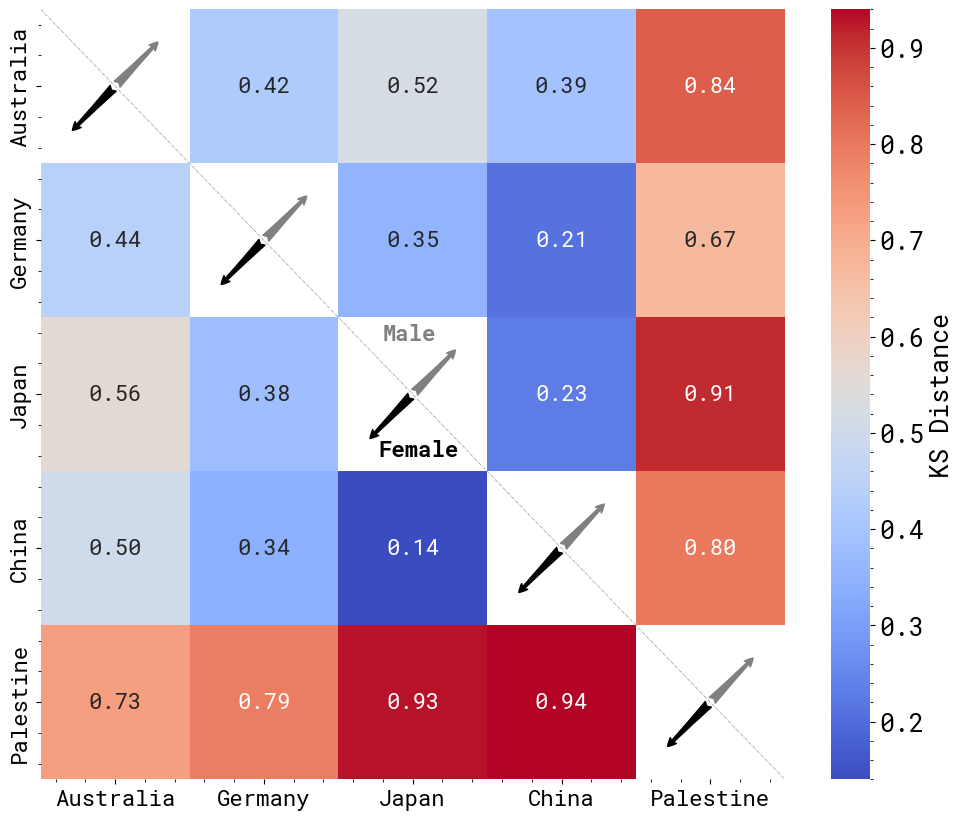

In [170]:
# KS distances between countries for the female population ALL
# aus-female vs ger-female: 0.44
# aus-female vs jap-female: 0.56
# aus-female vs chn-female: 0.50
# aus-female vs pal-female: 0.77
# ger-female vs jap-female: 0.38
# ger-female vs chn-female: 0.34
# ger-female vs pal-female: 0.79
# jap-female vs chn-female: 0.14
# jap-female vs pal-female: 0.93
# chn-female vs pal-female: 0.94
# Filtered to mid densities
ks_distances_female = np.array(
    [
        [np.nan, 0.44, 0.56, 0.50, 0.73],
        [np.nan, np.nan, 0.38, 0.34, 0.79],
        [np.nan, np.nan, np.nan, 0.14, 0.93],
        [np.nan, np.nan, np.nan, np.nan, 0.94],
        [np.nan, np.nan, np.nan, np.nan, np.nan],
    ]
)
# aus-male vs ger-male: 0.42
# aus-male vs jap-male: 0.52
# aus-male vs chn-male: 0.39
# aus-male vs pal-male: 0.84
# ger-male vs jap-male: 0.35
# ger-male vs chn-male: 0.21
# ger-male vs pal-male: 0.67
# jap-male vs chn-male: 0.23
# jap-male vs pal-male: 0.91
# chn-male vs pal-male: 0.80
# KS distances for the male population mid densities
ks_distances_male = np.array(
    [
        [np.nan, 0.42, 0.52, 0.39, 0.84],
        [0.42, np.nan, 0.35, 0.21, 0.67],
        [0.52, 0.35, np.nan, 0.23, 0.91],
        [0.39, 0.21, 0.23, np.nan, 0.80],
        [0.84, 0.67, 0.91, 0.80, np.nan],
    ]
)
# Combining male and female KS distances into a symmetric matrix
# Upper triangle (including diagonal): Male
# Lower triangle: Female
combined_ks_distances = np.triu(ks_distances_male, k=0) + np.tril(ks_distances_female.T, k=-1)
print(f"{combined_ks_distances = }")
countries_female = ["Australia", "Germany", "Japan", "China", "Palestine"]
# Plotting the combined heatmap
plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    combined_ks_distances,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    xticklabels=countries_female,
    yticklabels=countries_female,
    cbar_kws={"label": "KS Distance"},
    annot_kws={"size": 16},
)
ax.figure.axes[-1].yaxis.label.set_size(18)
cbar = ax.collections[0].colorbar
cbar.set_label("KS Distance", fontsize=18)
cbar.ax.tick_params(labelsize=18)

# Add some labels to show that the upper triangle is female and lower triangle is male
plt.plot([0, len(countries_female)], [0, len(countries_female)], "-.",color="gray", linewidth=0.4)
# Add two upward diagonal arrows for female
diagonal_coords = [
    (0.5, 0.5),
    (1.5, 1.5),
    (2.5, 2.5),
    (3.5, 3.5),
    (4.5, 4.5)
    ]
for i, (x, y) in enumerate(diagonal_coords):
    # Add an arrow for each diagonal cell
    arrow = FancyArrowPatch((x, y), (x + 0.3, y - 0.3), mutation_scale=15, color="gray", lw=1, arrowstyle='Fancy')
    ax.add_patch(arrow)

# Loop to add 5 male arrows, starting from each diagonal point (upward direction)
for i, (x, y) in enumerate(diagonal_coords):
    arrow_m = FancyArrowPatch((x, y), (x - 0.3, y + 0.3), mutation_scale=15, color="black", lw=1, arrowstyle='Fancy')
    ax.add_patch(arrow_m)

# Add text labels for male
plt.text(2.3, 2.15, 'Male', fontsize=16, fontweight='bold', color='gray')
# Add text labels for female
plt.text(2.27, 2.9, 'Female', fontsize=16, fontweight='bold', color='black')


# plt.title('Combined KS Distance Heatmap (Upper: Male, Lower: Female)')
plt.xticks(size=16)  # Larger x-axis labels
plt.yticks(size=16)  # Larger y-axis labels
plt.savefig("FD/KS_distance_heatmap_male_female5.pdf", dpi=100)

In [ ]:
# Corrected approach: Creating separate heatmaps for each scenario

# KS distances for sorted-mixed populations
# ks_distances_sorted_mixed = np.array(
#     [
#         [np.nan, 0.30, 0.19, 0.54],
#         [0.30, np.nan, 0.21, 0.16],
#         [0.19, 0.21, np.nan, 0.22],
#         [0.54, 0.16, 0.22, np.nan],
#     ]
# )

# # Country names for sorted-mixed
# countries_sorted_mixed = ["Australia", "Germany", "China", "Palestine"]


# # KS distances for random-mixed populations
# ks_distances_random_mixed = np.array(
#     [
#         [np.nan, 0.37, 0.48, 0.38],
#         [0.37, np.nan, 0.29, 0.16],
#         [0.48, 0.29, np.nan, 0.24],
#         [0.38, 0.16, 0.24, np.nan],
#     ]
# )

# max_ks_distance = max(
#     np.nanmax(ks_distances_sorted_mixed), np.nanmax(ks_distances_random_mixed)
# )
# print(max_ks_distance)
# # Country names for random-mixed
# countries_random_mixed = ["Australia", "Germany", "Japan", "China"]

# # Plotting the heatmap for sorted-mixed
# plt.figure(figsize=(8, 6))
# ax = sns.heatmap(
#     ks_distances_sorted_mixed,
#     annot=True,
#     fmt=".2f",
#     cmap="coolwarm",
#     xticklabels=countries_sorted_mixed,
#     yticklabels=countries_sorted_mixed,
#     cbar_kws={'label': 'KS Distance'},
#     vmin=0,
#     vmax=max_ks_distance,
#     annot_kws={'size':16}
# )
# ax.figure.axes[-1].yaxis.label.set_size(18)
# cbar = ax.collections[0].colorbar
# cbar.ax.tick_params(labelsize=16)
# #plt.title("KS Distance Heatmap for Sorted-Mixed Populations")
# plt.xticks(size=16) # Larger x-axis labels
# plt.yticks(size=16) # Larger y-axis labels
# plt.savefig("FD/KS_distance_heatmap_sorted_mix.pdf", dpi=100)

# plt.show()


# # Plotting the heatmap for random-mixed
# plt.figure(figsize=(8, 6))
# ax = sns.heatmap(
#     ks_distances_random_mixed,
#     annot=True,
#     fmt=".2f",
#     cmap="coolwarm",
#     xticklabels=countries_random_mixed,
#     yticklabels=countries_random_mixed,
#     cbar_kws={"label": "KS Distance"},
#     vmin=0,
#     vmax=max_ks_distance,
#     annot_kws={'size':16}
# )
# ax.figure.axes[-1].yaxis.label.set_size(18)
# #plt.title("KS Distance Heatmap for Random-Mixed Populations", size=16)

# plt.xticks(size=16) # Larger x-axis labels
# plt.yticks(size=16) # Larger y-axis labels
# plt.savefig("FD/KS_distance_heatmap_random_mix.pdf", dpi=100)
# plt.show()